In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, f1_score, precision_score, recall_score, auc, roc_curve, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)

In [98]:
# load dataset
df = pd.read_csv('creditcard.csv')

# Train-Test Split and Normalizing

In the previous notebook, we decided to apply RobustScaler to normalize `Amount` and `Time` column, we will do this here after train-test split.

In [3]:
# assign independent and target variables
X = df.drop(columns='Class')

y = df['Class']

In [4]:
# since I am using k-fold cross validation I do not need a separate validation set
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# normalize Amount and Time columns
rs = RobustScaler()

# fit transform
X_train['Amount'] = rs.fit_transform(X_train['Amount'].values.reshape(-1,1))
X_train['Time'] = rs.fit_transform(X_train['Time'].values.reshape(-1,1))
X_test['Amount'] = rs.fit_transform(X_test['Amount'].values.reshape(-1,1))
X_test['Time'] = rs.fit_transform(X_test['Time'].values.reshape(-1,1))

# check
display(X_train.head())
display(X_test.head())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
223361,0.688774,1.955041,-0.380783,-0.315013,0.330155,-0.509374,-0.086197,-0.627978,0.035994,1.054560,-0.030441,0.624996,1.691496,1.255790,-0.253266,-0.331695,0.307252,-0.930844,0.651666,0.167987,-0.125390,0.238197,0.968305,0.053208,-0.278602,-0.044999,-0.216780,0.045168,-0.047145,-0.167972
165061,0.381307,-0.400975,-0.626943,1.555339,-2.017772,-0.107769,0.168310,0.017959,-0.401619,0.040378,0.611115,-1.945070,-0.726597,1.060888,-1.193347,0.631053,-0.160123,-1.630444,2.106866,-1.692780,-0.470372,-0.153485,0.421703,0.113442,-1.004095,-1.176695,0.361924,-0.370469,-0.144792,0.334266
238186,0.761745,0.072509,0.820566,-0.561351,-0.709897,1.080399,-0.359429,0.787858,0.117276,-0.131275,-0.638222,0.521931,-0.072768,-1.008237,-0.640249,-0.801946,0.678131,0.044374,0.521919,0.198772,0.012227,-0.314638,-0.872959,0.083391,0.148178,-0.431459,0.119690,0.206395,0.070288,-0.140000
150562,0.105269,-0.535045,1.014587,1.750679,2.769390,0.500089,1.002270,0.847902,-0.081323,0.371579,0.560595,-0.855437,-4.179628,0.286872,1.271254,-1.011647,1.458600,-0.613260,0.814931,-2.147124,-0.253757,0.063525,0.443431,-0.072754,0.448192,-0.655203,-0.181038,-0.093013,-0.064931,1.334825
138452,-0.024100,-4.026938,1.897371,-0.429786,-0.029571,-0.855751,-0.480406,-0.435632,1.313760,0.536044,1.221746,0.472626,1.595929,0.777603,0.187685,-1.060579,0.143332,0.007803,-0.055817,0.712695,-0.012320,-0.480691,-0.230369,0.250717,0.066399,0.470787,0.245335,0.286904,-0.322672,0.052587


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
43428,-0.507431,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,-14.110184,5.299236,-10.834006,1.671120,-9.373859,0.360806,-9.899247,-19.236292,-8.398552,3.101735,-1.514923,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,4.759249
49906,-0.475033,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,-0.565012,-0.087670,0.979427,0.076883,-0.217884,-0.136830,-2.142892,0.126956,1.752662,0.432546,0.506044,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,6.927955
29474,-0.578211,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,0.756801,0.543827,0.112453,1.075384,-0.245772,0.180483,1.769860,-0.533172,-0.533300,1.192245,0.212877,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,0.125174
276481,0.969268,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,-1.376648,-1.328335,0.223621,1.132627,-0.550875,0.616568,0.497974,0.502195,0.981343,0.101264,-0.244633,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,-0.285118
278846,0.985138,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,0.259452,0.942162,0.850038,-0.616166,0.592634,-0.603845,0.091077,-0.471867,-0.333816,0.404711,-0.255293,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,-0.293602


Remeber that we observed outliers in the dataset, we will train the models including the outliers and excluding them to compare the models' performance.

# Modelling (Undersampling with Outliers)

There are two ways to deal with imbalanced dataset like this one, oversampling and undersampling. Due to the large size of this dataset, oversampling might be too computational expensive for hyperparameter tuning process, I will only perform undersampling technique in 
this notebook. Additionally I am implementing resampling technique within cross-validation for the following reasons:

- By resampling within each fold, you ensure that the test (or validation) data in that fold is completely unseen and unaffected by the resampling process. This prevents information leakage, where the model indirectly learns about the test data during training, leading to overly optimistic performance estimates.
- The test set within each fold should mimic the real-world distribution of classes, including any imbalances. This ensures that performance metrics reflect how the model will perform in actual deployment scenarios, providing a realistic assessment of its capabilities.
- By applying resampling strategies like undersampling, oversampling, or SMOTE within each fold, you effectively create slightly different "versions" of your training data for each fold. This allows the model to learn from a variety of scenarios, potentially improving its robustness and ability to generalize to unseen data.
- Implementing resampling strategies within each fold ensures that the model has a balanced learning environment during training. This helps in reducing the bias towards the majority class, which is particularly important in imbalanced datasets to ensure that the minority class is adequately represented and learned.

In [91]:
# base models to try
models = {
     'Logistic Regression': LogisticRegression(C=0.01),
     'KNN': KNeighborsClassifier(),
     'Decision Tree': DecisionTreeClassifier(),
     'Random Forest': RandomForestClassifier(),
     'XGBoost': xgb.XGBClassifier()
}

sfk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = ['accuracy', 'precision', 'recall', 'f1']

for name, model in models.items():
    
    pipeline = make_pipeline(RandomUnderSampler(random_state=42),model)
    
    # Note the change here: using a variable specific to this iteration
    cv_results = cross_validate(pipeline, X_train, y_train, cv=sfk, scoring=scoring, return_train_score=True)
    
    print(f"\n{name} Results:")
    for metric in scoring:
        train_metric_mean = np.mean(cv_results[f'train_{metric}'])
        train_metric_std = np.std(cv_results[f'train_{metric}'])
        test_metric_mean = np.mean(cv_results[f'test_{metric}'])
        test_metric_std = np.std(cv_results[f'test_{metric}'])
        print(f"{metric.capitalize()} (Train): {train_metric_mean:.4f} (+/- {train_metric_std * 2:.4f})")
        print(f"{metric.capitalize()} (Test): {test_metric_mean:.4f} (+/- {test_metric_std * 2:.4f})")


Logistic Regression Results:
Accuracy (Train): 0.9871 (+/- 0.0017)
Accuracy (Test): 0.9871 (+/- 0.0023)
Precision (Train): 0.1083 (+/- 0.0118)
Precision (Test): 0.1082 (+/- 0.0188)
Recall (Train): 0.8871 (+/- 0.0169)
Recall (Test): 0.8808 (+/- 0.0564)
F1 (Train): 0.1930 (+/- 0.0184)
F1 (Test): 0.1926 (+/- 0.0303)

KNN Results:
Accuracy (Train): 0.9731 (+/- 0.0079)
Accuracy (Test): 0.9729 (+/- 0.0091)
Precision (Train): 0.0569 (+/- 0.0146)
Precision (Test): 0.0553 (+/- 0.0166)
Recall (Train): 0.9181 (+/- 0.0129)
Recall (Test): 0.8884 (+/- 0.0537)
F1 (Train): 0.1071 (+/- 0.0258)
F1 (Test): 0.1040 (+/- 0.0294)

Decision Tree Results:
Accuracy (Train): 0.9039 (+/- 0.0181)
Accuracy (Test): 0.9034 (+/- 0.0179)
Precision (Train): 0.0178 (+/- 0.0035)
Precision (Test): 0.0162 (+/- 0.0040)
Recall (Train): 1.0000 (+/- 0.0000)
Recall (Test): 0.9062 (+/- 0.0742)
F1 (Train): 0.0351 (+/- 0.0068)
F1 (Test): 0.0317 (+/- 0.0078)

Random Forest Results:
Accuracy (Train): 0.9722 (+/- 0.0134)
Accuracy (Te

High **Recall** in fraud detection means catching a high number of fraudulent transactions. Your models show varying Recall scores, with Decision Tree, Random Forest, and XGBoost. They have particularly high recall scores, but very low **Precision** scores, meaning they are good at identifying fraudulent transactions but they also tend to incorrectlty flag the non-fraudulent transactions as fraudulent ones.
The **F1** score is the harmonic mean of precision and recall and gives an overall measure of a model's accuracy in terms of these two metrics. In scenarios like this, we prefer models with higher F1 scores, indicating a balance between precision and recall. Based on our results, Logistic Regression has the highest accuracy and F1 score, suggesting a balance, we will use this model for hyperparameter tuning.

## Hyperparameter Tuning

In [26]:
# set up pipeline with placeholders
pipeline = imbpipeline(steps = [['resampler', RandomUnderSampler()],
                                ['model', LogisticRegression()]])

# set up a hyperparameter grid 
param_grid_logreg =[ 
    
    # l2 only
    {'resampler': [RandomUnderSampler(random_state=42)],
     'model__penalty': ['l2'],
     'model__C': [0.001,0.01,0.1,1,10,100,1000], 
     'model__solver': ['lbfgs', 'newton-cg','saga'],
     'model__warm_start': [True, False],
     'model__n_jobs':[-1],
     'model__max_iter':[500,1000]},

    {'resampler': [RandomUnderSampler(random_state=42)],
     'model__penalty': ['l1','l2'],
     'model__C': [0.001,0.01,0.1,1,10,100,1000], 
     'model__solver': ['liblinear'],
     'model__warm_start': [True, False],
     'model__max_iter':[500,1000]}
]


# set up stratifiedkfold for cross validation
stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=1)

# instantiate randomized search
gs_logreg = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid_logreg,
                               scoring='f1',
                               cv=stratified_kfold,
                               n_jobs=-1)

# fit
gs_logreg.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[['resampler', RandomUnderSampler()],
                                       ['model', LogisticRegression()]]),
             n_jobs=-1,
             param_grid=[{'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'model__max_iter': [500, 1000], 'model__n_jobs': [-1],
                          'model__penalty': ['l2'],
                          'model__solver': ['lbfgs', 'newton-cg', 'saga'],
                          'model__warm_start': [True, False],
                          'resampler': [RandomUnderSampler(random_state=42)]},
                         {'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'model__max_iter': [500, 1000],
                          'model__penalty': ['l1', 'l2'],
                          'model__solver': ['liblinear'],
                          'model__warm_start': [True, False],
                          'resampler': [RandomUnderSampler(random_state=42)]}],
             scoring='f1')

In [92]:
# Print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", gs_logreg.best_params_)
print("Best Score: ", gs_logreg.best_score_)

Best Hyperparameters:  {'model__C': 0.001, 'model__max_iter': 1000, 'model__n_jobs': -1, 'model__penalty': 'l2', 'model__solver': 'saga', 'model__warm_start': False, 'resampler': RandomUnderSampler(random_state=42)}
Best Score:  0.5358348104968987


In [93]:
# fit a new model with optimized hyperparameters
logreg_tuned = LogisticRegression(warm_start=False,solver='saga', penalty='l2',C=0.001,max_iter=1000,random_state=42,n_jobs=-1)

rs = RandomUnderSampler(random_state=42)
X_train_us,y_train_us = rs.fit_resample(X_train,y_train)

# fit on undersampled train set
logreg_tuned.fit(X_train_us,y_train_us)

# predict on test set
y_pred_logreg_tuned = logreg_tuned.predict(X_test)

# get scores
print(f'Accuracy on train set: {round(logreg_tuned.score(X_train_us, y_train_us),4)}') 
print(f'Accuracy on test set: {round(logreg_tuned.score(X_test, y_test),4)}') 
print(f'Recall on test set: {round(recall_score(y_test, y_pred_logreg_tuned),4)}') 
print(f'Precision on test set: {round(precision_score(y_test, y_pred_logreg_tuned),4)}') 
print(f'F1 on test set: {round(f1_score(y_test, y_pred_logreg_tuned),4)}')
print(f'ROC/AUC on test set: {round(roc_auc_score(y_test,logreg_tuned.predict_proba(X_test)[:,1]),4)}')

Accuracy on train set: 0.915
Accuracy on test set: 0.9968
Recall on test set: 0.8367
Precision on test set: 0.3267
F1 on test set: 0.4699
ROC/AUC on test set: 0.9865


- Test accuracy is notably higher, this might due to the nature and the undersampling method we used (in order to balance the two classes, the size of the training set was cut down significantly during cross-validation, the model could not learn the complex pattern).
- Precision measures the proportion of positive identifications (fraud) that were actually correct. A precision of 32.67% is relatively low, indicating that a significant portion of transactions flagged as fraudulent by the model are false positives (non-fraudulent transactions incorrectly marked as fraud). The F1 score is the harmonic mean of precision and recall, providing a single metric to assess the balance between them. An F1 score of 46.99% is moderate, suggesting that the model doesn't perfectly balance precision and recall. But we can achieve a balance between precision and recall by adjusting the predicting threshold later.
- An AUC-ROC of 98.65% is excellent and indicates a high level of discriminative power between fraudulent and non-fraudulent transactions. This suggests that, overall, the model does a good job differentiating between the two classes.

# Modelling (Undersampling without Outliers)

In the previous EDA, we discusses there are outliers present in the dataset, and the reason we are only going to remove the outliers from the non-fraud group of features `V10`, `V12`, `V14`, and `V17`.

In [99]:
features = ['V10','V12','V14','V17']

for i in features:
    
    # define first, third quantile and IQR
    Q1 = df.loc[df['Class'] == 0, i].quantile(0.25)
    Q3 = df.loc[df['Class'] == 0, i].quantile(0.75)
    IQR = Q3 - Q1
    
    # get indices of outliers
    outlier_indices = df.index[(df[i] < (Q1 - 1.5 * IQR)) | (df[i] > (Q3 + 1.5 * IQR)) & (df['Class'] == 0)]

    # drop outliers
    df_filtered = df.drop(index=outlier_indices)

In [101]:
# check 
print(f"Original data: {df.shape}")
print(f"After removing outliers: {df_filtered.shape}")

Original data: (284807, 31)
After removing outliers: (277411, 31)


In [102]:
# assign independent and target variables without outliers
X_no = df_filtered.drop(columns='Class')

y_no = df_filtered['Class']

# since I am using k-fold cross validation I do not need a separate validation set
#train-test split
X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(X_no, y_no, test_size=0.2, random_state=42)

# normalize Amount and Time columns
rs = RobustScaler()

# fit transform
X_train_no['Amount'] = rs.fit_transform(X_train_no['Amount'].values.reshape(-1,1))
X_train_no['Time'] = rs.fit_transform(X_train_no['Time'].values.reshape(-1,1))
X_test_no['Amount'] = rs.fit_transform(X_test_no['Amount'].values.reshape(-1,1))
X_test_no['Time'] = rs.fit_transform(X_test_no['Time'].values.reshape(-1,1))

# check
display(X_train_no.head())
display(X_test_no.head())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
160953,0.343218,2.073984,-0.101378,-1.643892,-0.049346,0.490097,-0.312578,0.042090,-0.107173,0.548007,0.074570,0.479367,0.739870,-0.078272,0.668782,0.252219,0.085642,-0.977297,0.790017,0.297519,-0.208149,0.281248,0.917916,-0.059771,0.214038,0.385175,-0.439785,-0.001789,-0.062511,-0.300725
160877,0.342889,2.068678,-0.025016,-1.586618,-0.039083,0.539425,-0.337469,0.113287,-0.170761,0.387317,0.044417,0.730617,1.311964,0.929004,0.470483,0.133764,0.012610,-1.004459,0.636536,0.258210,-0.145434,0.298655,1.017478,-0.061413,0.328145,0.408291,-0.448543,0.005007,-0.059443,-0.300725
12422,-0.739244,1.009663,-0.402104,1.803011,1.843215,-1.111844,1.071458,-1.184511,0.400918,2.752473,-0.604846,0.884892,-1.150204,1.401327,0.531004,-3.006538,-0.252756,0.679132,0.663230,0.375725,-0.124091,-0.168954,0.160417,-0.165813,-0.001869,0.535526,-0.264290,0.071673,0.024639,0.270883
231325,0.731159,-1.987100,1.542141,0.675893,3.101858,-0.838815,0.788369,-1.247388,1.630078,-1.175016,0.784712,-0.786431,-0.362212,-1.344844,0.937657,-0.946318,2.031074,-0.822005,1.204885,-1.060315,-0.692293,0.377386,0.429439,0.071768,-0.418325,-1.318173,-0.270389,-0.628494,0.022823,-0.007600
169770,0.415068,-0.529127,0.240728,1.751979,0.761905,0.438201,0.553619,0.283446,0.147002,-0.183826,0.042680,0.660082,-0.159391,-0.957767,0.176882,0.598825,0.110319,-0.676796,1.198511,0.528015,0.231073,0.334403,0.963684,-0.127783,0.671129,-0.127148,-0.448748,-0.002979,-0.064543,0.480198


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
91249,-0.255554,1.124493,-0.121886,0.845802,0.255387,-1.061946,-1.255242,-0.091887,-0.217127,0.216521,-0.199686,0.334217,0.613656,0.440192,0.102920,1.168323,0.330597,-0.224298,-0.728486,-0.214490,0.056922,-0.173447,-0.633281,0.190327,0.968737,-0.077984,0.703431,-0.074613,0.029680,0.518261
232829,0.729623,-0.293941,0.675712,0.768133,-1.264782,0.940361,-0.501173,1.288177,-0.232927,-0.259936,-0.521275,0.170593,-0.045245,-1.136365,0.312535,-1.227638,0.371572,-1.042025,-0.022802,-0.019150,-0.158337,-0.251440,-0.629541,-0.180313,-0.524857,-0.316263,0.065446,-0.123845,-0.104551,-0.190112
167511,0.394076,-0.717145,1.520293,-0.578808,-0.519493,0.352069,-1.189321,0.876315,-0.090522,0.396124,0.423865,-0.927625,0.106053,0.177531,0.329997,0.522660,-0.504247,-0.410043,0.048321,-0.063754,0.176558,0.317879,1.337519,-0.069383,-0.049998,-0.696651,-0.241859,0.301172,0.157335,-0.301208
270040,0.924091,0.117684,1.163625,0.890576,2.404185,1.379475,0.918921,1.063905,0.039772,-1.808957,1.136753,0.333796,0.060874,0.261947,0.094873,-1.111263,1.550656,-1.651485,-0.075927,-1.323523,-0.035807,-0.378767,-1.235941,0.329416,0.077061,-0.840173,-0.758044,-0.162974,-0.205452,0.226635
2277,-0.977983,-3.073061,1.554733,0.728721,-0.937444,0.928604,4.974130,-0.786162,0.866337,2.455404,4.730622,-0.925925,-0.260475,-0.080031,-2.596456,-0.917732,-2.740438,0.091664,1.458856,0.670220,1.563420,-1.093590,-0.809802,-0.279722,0.956479,1.000490,-0.093529,1.149422,0.426914,-0.037217


In [103]:
# base models to try
models = {
     'Logistic Regression': LogisticRegression(C=0.01),
     'KNN': KNeighborsClassifier(),
     'Decision Tree': DecisionTreeClassifier(),
     'Random Forest': RandomForestClassifier(),
     'XGBoost': xgb.XGBClassifier()
}

sfk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = ['accuracy', 'precision', 'recall', 'f1']

for name, model in models.items():
    
    pipeline = make_pipeline(RandomUnderSampler(random_state=42),model)
    
    # Note the change here: using a variable specific to this iteration
    cv_results = cross_validate(pipeline, X_train_no, y_train_no, cv=sfk, scoring=scoring, return_train_score=True)
    
    print(f"\n{name} Results:")
    for metric in scoring:
        train_metric_mean = np.mean(cv_results[f'train_{metric}'])
        train_metric_std = np.std(cv_results[f'train_{metric}'])
        test_metric_mean = np.mean(cv_results[f'test_{metric}'])
        test_metric_std = np.std(cv_results[f'test_{metric}'])
        print(f"{metric.capitalize()} (Train): {train_metric_mean:.4f} (+/- {train_metric_std * 2:.4f})")
        print(f"{metric.capitalize()} (Test): {test_metric_mean:.4f} (+/- {test_metric_std * 2:.4f})")


Logistic Regression Results:
Accuracy (Train): 0.9658 (+/- 0.0167)
Accuracy (Test): 0.9659 (+/- 0.0163)
Precision (Train): 0.0110 (+/- 0.0061)
Precision (Test): 0.0104 (+/- 0.0034)
Recall (Train): 0.7548 (+/- 0.0322)
Recall (Test): 0.7300 (+/- 0.1365)
F1 (Train): 0.0217 (+/- 0.0119)
F1 (Test): 0.0204 (+/- 0.0066)

KNN Results:
Accuracy (Train): 0.9228 (+/- 0.0193)
Accuracy (Test): 0.9223 (+/- 0.0189)
Precision (Train): 0.0051 (+/- 0.0008)
Precision (Test): 0.0051 (+/- 0.0014)
Recall (Train): 0.8438 (+/- 0.1095)
Recall (Test): 0.8367 (+/- 0.1285)
F1 (Train): 0.0102 (+/- 0.0016)
F1 (Test): 0.0101 (+/- 0.0028)

Decision Tree Results:
Accuracy (Train): 0.8083 (+/- 0.0366)
Accuracy (Test): 0.8099 (+/- 0.0354)
Precision (Train): 0.0025 (+/- 0.0004)
Precision (Test): 0.0019 (+/- 0.0003)
Recall (Train): 1.0000 (+/- 0.0000)
Recall (Test): 0.7786 (+/- 0.1878)
F1 (Train): 0.0049 (+/- 0.0009)
F1 (Test): 0.0038 (+/- 0.0005)

Random Forest Results:
Accuracy (Train): 0.9215 (+/- 0.0379)
Accuracy (Te

In [105]:
# instantiate randomized search
gs_logreg_no = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid_logreg,
                               scoring='f1',
                               cv=stratified_kfold,
                               n_jobs=-1)

# fit
gs_logreg_no.fit(X_train_no, y_train_no)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[['resampler', RandomUnderSampler()],
                                       ['model', LogisticRegression()]]),
             n_jobs=-1,
             param_grid=[{'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'model__max_iter': [500, 1000], 'model__n_jobs': [-1],
                          'model__penalty': ['l2'],
                          'model__solver': ['lbfgs', 'newton-cg', 'saga'],
                          'model__warm_start': [True, False],
                          'resampler': [RandomUnderSampler(random_state=42)]},
                         {'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'model__max_iter': [500, 1000],
                          'model__penalty': ['l1', 'l2'],
                          'model__solver': ['liblinear'],
                          'model__warm_start': [True, False],
                          'resampler': [RandomUnderSampler(random_state=42)]}],
             scoring='f1')

In [106]:
# Print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", gs_logreg_no.best_params_)
print("Best Score: ", gs_logreg_no.best_score_)

Best Hyperparameters:  {'model__C': 0.001, 'model__max_iter': 500, 'model__n_jobs': -1, 'model__penalty': 'l2', 'model__solver': 'lbfgs', 'model__warm_start': True, 'resampler': RandomUnderSampler(random_state=42)}
Best Score:  0.06304110034860322


In [108]:
# fit a new model with optimized hyperparameters
logreg_tuned_no = LogisticRegression(warm_start=True,solver='lbfgs', penalty='l2',C=0.001,max_iter=500,random_state=42,n_jobs=-1)

rs = RandomUnderSampler(random_state=42)
X_train_no_us,y_train_no_us = rs.fit_resample(X_train_no,y_train_no)

# fit on undersampled train set
logreg_tuned_no.fit(X_train_no_us,y_train_no_us)

# predict on test set
y_pred_logreg_tuned_no = logreg_tuned_no.predict(X_test_no)

# get scores
print(f'Accuracy on train set: {round(logreg_tuned_no.score(X_train_no_us, y_train_no_us),4)}') 
print(f'Accuracy on test set: {round(logreg_tuned_no.score(X_test_no, y_test_no),4)}') 
print(f'Recall on test set: {round(recall_score(y_test_no, y_pred_logreg_tuned_no),4)}') 
print(f'Precision on test set: {round(precision_score(y_test_no, y_pred_logreg_tuned_no),4)}') 
print(f'F1 on test set: {round(f1_score(y_test_no, y_pred_logreg_tuned_no),4)}')
print(f'ROC/AUC on test set: {round(roc_auc_score(y_test_no,logreg_tuned_no.predict_proba(X_test_no)[:,1]),4)}')

Accuracy on train set: 0.8413
Accuracy on test set: 0.9874
Recall on test set: 0.6333
Precision on test set: 0.0269
F1 on test set: 0.0516
ROC/AUC on test set: 0.9021


/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase

/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (

/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the co

Model is clearly underfitting, and performed so much worse than the model that with outliers. I will proceed without removing the outliers.

# Adjuting Predicting Thresholds

Threshold 0.6 Results:
Recall: 0.826530612244898
Precision: 0.43783783783783786
F1: 0.5724381625441697
ROC/AUC: 0.9865041402041965


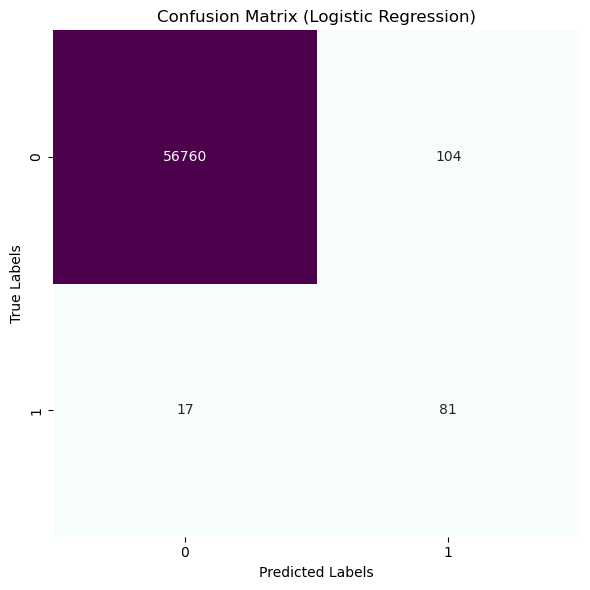

Threshold 0.65 Results:
Recall: 0.7959183673469388
Precision: 0.4968152866242038
F1: 0.6117647058823529
ROC/AUC: 0.9865041402041965


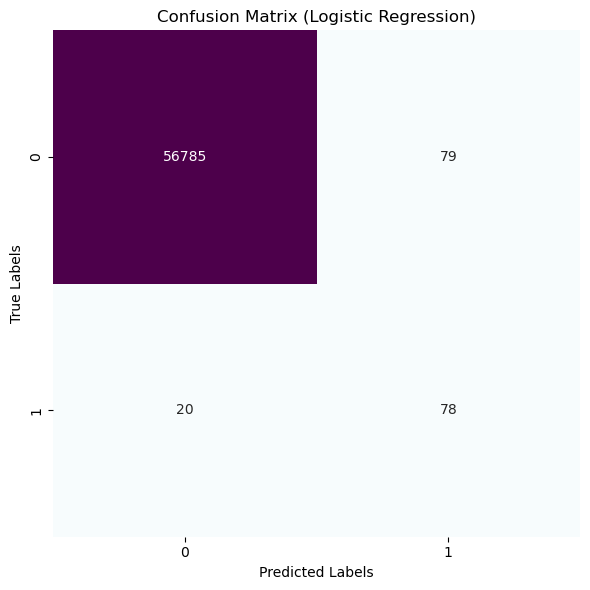

Threshold 0.7 Results:
Recall: 0.7755102040816326
Precision: 0.5352112676056338
F1: 0.6333333333333333
ROC/AUC: 0.9865041402041965


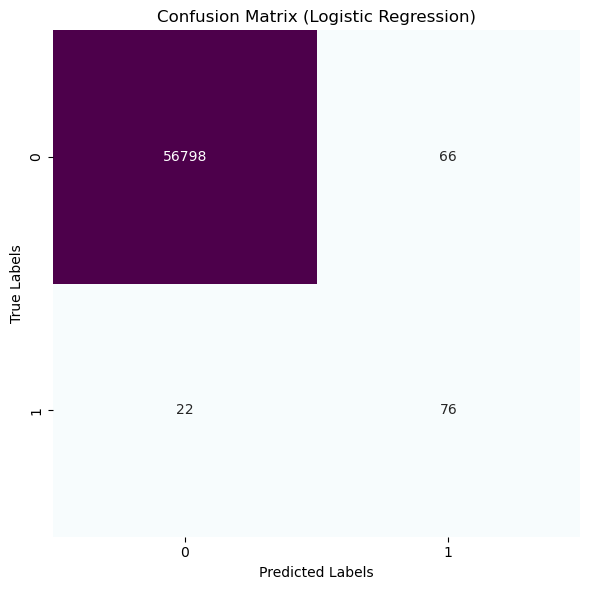

Threshold 0.75 Results:
Recall: 0.7653061224489796
Precision: 0.6097560975609756
F1: 0.6787330316742082
ROC/AUC: 0.9865041402041965


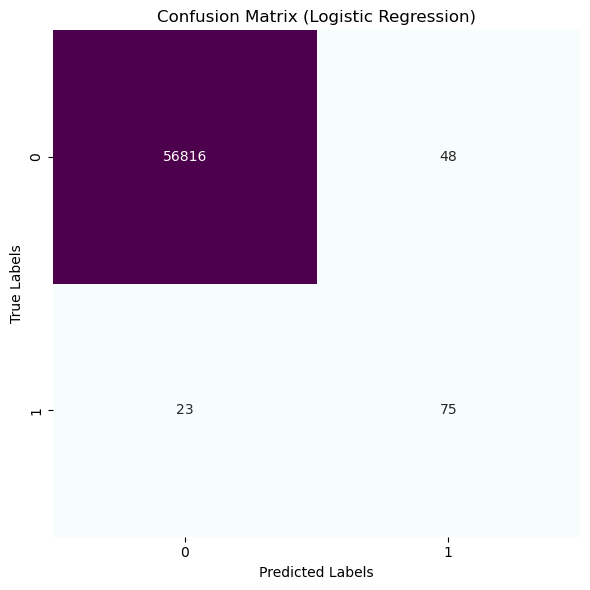

Threshold 0.8 Results:
Recall: 0.7040816326530612
Precision: 0.711340206185567
F1: 0.7076923076923078
ROC/AUC: 0.9865041402041965


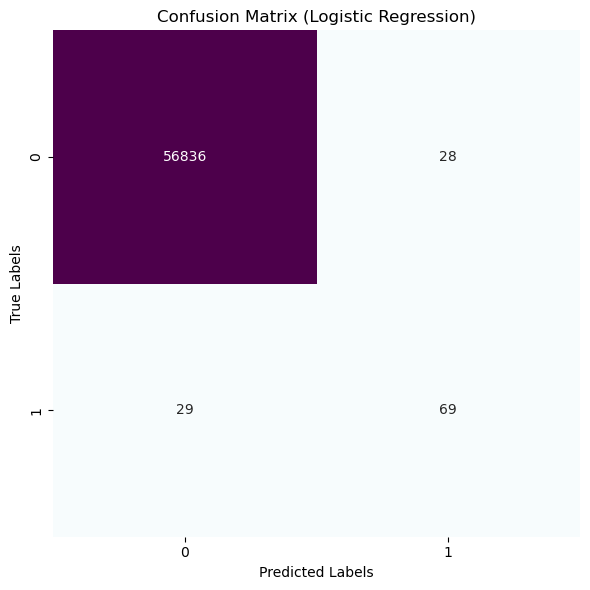

Threshold 0.85 Results:
Recall: 0.6428571428571429
Precision: 0.7974683544303798
F1: 0.711864406779661
ROC/AUC: 0.9865041402041965


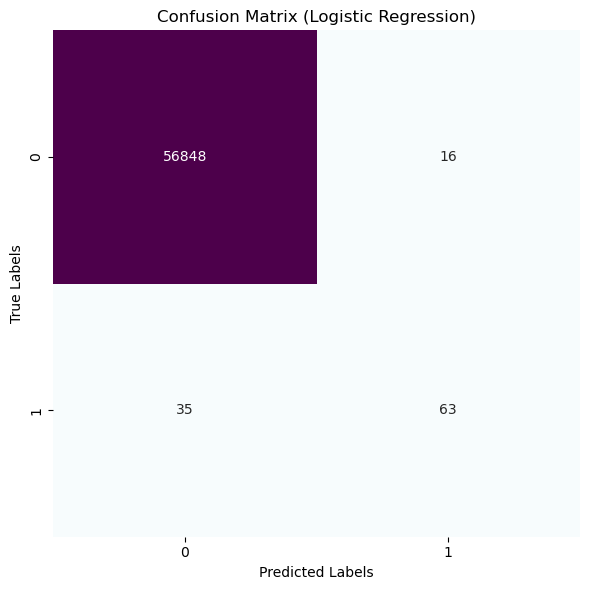

Threshold 0.9 Results:
Recall: 0.5816326530612245
Precision: 0.8142857142857143
F1: 0.6785714285714286
ROC/AUC: 0.9865041402041965


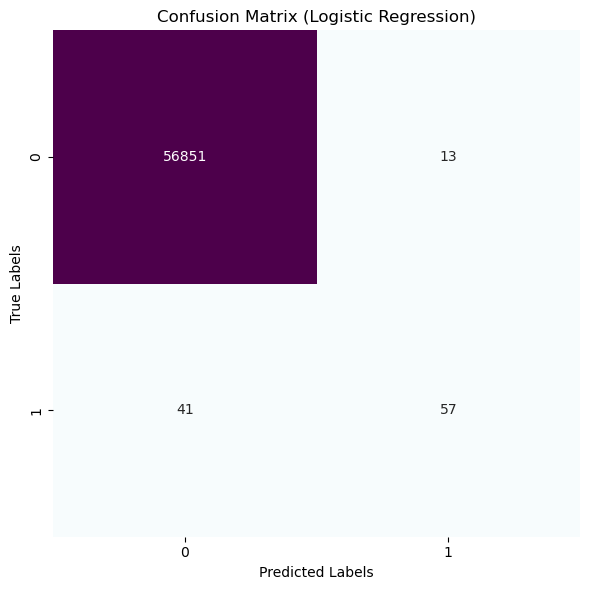

In [111]:
y_probs = logreg_tuned.predict_proba(X_test)[:,1]

thresholds = [0.6,0.65,0.7,0.75,0.8,0.85,0.9]

for threshold in thresholds:
    
    y_pred_th = (y_probs>=threshold).astype(int)
    
    print(f"Threshold {threshold} Results:")
    print(f"Recall: {recall_score(y_test, y_pred_th)}")
    print(f"Precision: {precision_score(y_test, y_pred_th)}")
    print(f"F1: {f1_score(y_test, y_pred_th)}")
    print(f"ROC/AUC: {roc_auc_score(y_test, y_probs)}")
    
    # confusion matrix

    cm = confusion_matrix(y_test, y_pred_th)
    
    # plot
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, cmap='BuPu', fmt='g', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix (Logistic Regression)')
    plt.tight_layout()
    plt.show()
    
    print("="*40)
    
    

**Bottom Line:**

When we increase the predicting threhold, the precision increases but the recall started to drop. This means fewer legitimate transactions are incorrectly flagged, but more fraudulent transactions might be missed. 

Here is the trade-off when increasing the threshold, the model risks missing fraudulent transactions, which can have significant implications and damage customer trust.

On the other hand, if the precision is too low, then we risk impacting customer experience. A model too sensitive to fraud (low threshold) may frequently interrupt users with authetication challenges or block transactions, potentially leading to frustration and churn. 

Financial institues should consider associated with false positives and false negatives. Ajust the threshold to minimize the total cost.